# 训练部分附图

## 研究区位图

### Load data (for sampling)

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from function.global_varibles import PATHS
from function import *
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')
us_argscv = gpd.read_file("figure/draw_shp/ASD_2012_5m.shp")
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')
us_argscv_4326 = us_argscv.to_crs('EPSG:4326')

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)
df_abandon_filtered=df_abandon_filtered.merge(df_net_benefit[['lon', 'lat', 'area_m2']], on=['lat', 'lon'], how='left')


gogogo
You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值


### Helper function for plot

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

def _setup_axes_and_graticule(ax, usa_bounds_main, proj_fwd, proj_inv):
    """设置坐标轴和经纬度网格"""
    # 设置数据框线
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color('black')

    # 经纬度刻度
    lon_ticks = np.arange(-125, -55, 10)
    lat_ticks = [25, 30, 35, 40, 45, 50]
    
    # 绘制网格线和设置刻度
    _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)


def _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线
    xticks, xlabels = [], []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        p = _choose_point_on_edge(line.intersection(bottom))
        if p is None:
            p = _choose_point_on_edge(line.intersection(top))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # 2%的图宽
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                xlabels.append(f"{abs(int(round(lon)))}°W")

        if i <= len(lon_ticks) :
            ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # 纬度网格线（刻度不显示）
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # 刻度不显示
    ax.xaxis.set_major_locator(mticker.NullLocator())
    ax.xaxis.set_major_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_locator(mticker.NullLocator())
    ax.yaxis.set_major_formatter(mticker.NullFormatter())
    ax.tick_params(axis='both', labelsize=5, pad=1, length=0)



def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes



def _draw_background_map(ax, usa_bounds_main):
    """绘制背景地图"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")

弃光面积统计: 最小值=0.00 ha, 最大值=515459.22 ha
分位数边界: [  4842.57554868  31649.44167715  64815.69337036 100516.81501499
 184895.73195452]
开始聚合embedding点，总数: 10152
地理区划聚合结果: 312个区划
包含embedding点的区划数: 236
Embedding点数量分布: 最小0.0, 最大1113.0
气泡分类统计:
  >1000点: 3个区划 (深绿色, 80)
  800-1000点: 0个区划 (绿色, 60)
  100-800点: 18个区划 (浅绿色, 40)
  50-100点: 13个区划 (浅蓝色, 25)
  10-50点: 63个区划 (蓝色, 15)
  <10点: 215个区划（不绘制）
Embedding点聚合完成: 原始10152个点 → 312个地理区划


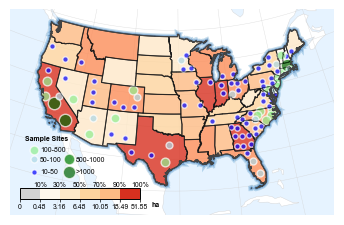

In [26]:
def plot_smaplesites_nature_style(
    df_abandon_filtered, 
    us_counties_4326, 
    df_pv_embedding,
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """
    参数:
        df_abandon_filtered: DataFrame，包含要绘制的撂荒点，必须包含'lat'、'lon'和'area_m2'列
        us_counties_4326: GeoDataFrame，美国各县边界
        df_pv_embedding: DataFrame，包含要绘制的embedding数据，必须包含'lat'和'lon'列
        add_north_arrow_and_scalebar: bool, 是否添加指北针和比例尺
        add_embedding_points: bool, 是否绘制embedding点

        按照county聚合df_abandon_filtered的面积，然后以分位数划分绘制
        以气泡聚合的形式绘制df_pv_embedding的点
    """
    
    # ==================== 1. 初始设置 ====================
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # 创建图形和坐标轴
    fig, ax = plt.subplots(1, 1, figsize=(100/25.4, 60/25.4))
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff')

    # ==================== 2. 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理县界数据
    us_counties_bound = us_counties_4326.to_crs(epsg=4326).clip(bbox)
    us_counties_albers = us_counties_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_counties_albers.total_bounds

    # 边界调整
    margin_x_left = (xmax - xmin) * 0.08   # 增大左边界
    margin_x_right = (xmax - xmin) * 0.02  # 减小右边界
    margin_y = (ymax - ymin) * 0.08

    # 在ymin留更多空给color bar
    colorbar_space = (ymax - ymin) * 0.08  
    xmin = xmin - margin_x_left
    xmax = xmax + margin_x_right
    ymin = ymin - margin_y * 1 - colorbar_space
    ymax = ymax + margin_y * 0.8

    # 画布比例调整
    fig_width, fig_height = fig.get_size_inches()
    aspect_ratio = fig_width / fig_height
    data_width = xmax - xmin
    data_height = ymax - ymin
    data_aspect = data_width / data_height
    
    if data_aspect > aspect_ratio:
        # 数据过宽，调整y范围，保持中心
        center_y = (ymin + ymax) / 2
        new_height = data_width / aspect_ratio
        ymin = center_y - new_height / 2
        ymax = center_y + new_height / 2
        # 适度放大y范围，避免边界裁切
        ymin *= 1.05
        ymax *= 1.05
    else:
        # 数据偏高，调整x范围，保持中心
        center_x = (xmin + xmax) / 2
        new_width = data_height * aspect_ratio
        xmin = center_x - new_width / 2
        xmax = center_x + new_width / 2
        # 适度收缩x范围，突出主体
        xmin *= 0.9
        xmax *= 1

    # 设置坐标轴位置和范围
    ax.set_position([0.0, 0.08, 1, 0.87])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. 地图元素绘制 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制县界
    us_counties_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 6. 坐标轴设置 ====================
    _setup_axes_and_graticule(ax, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 7. 背景地图 ====================
    _draw_background_map(ax, usa_bounds_main)

    # ==================== 8. 数据可视化 ====================
    # 绘制df_abandon_filtered的面积在county上的聚合
    # 1. 先将弃光点转为GeoDataFrame
    gdf_abandon = gpd.GeoDataFrame(
        df_abandon_filtered,
        geometry=gpd.points_from_xy(df_abandon_filtered['lon'], df_abandon_filtered['lat']),
        crs='EPSG:4326'
    )
    # 2. 投影到Albers
    gdf_abandon = gdf_abandon.to_crs('ESRI:102003')
    # 3. 空间连接到county，统计每个county的弃光面积总和
    county_abandon_area = gpd.sjoin(
        gdf_abandon, us_counties_albers, how='left', predicate='within'
    ).groupby('index_right')['area_m2'].sum()
    # 4. 合并回county GeoDataFrame
    us_counties_albers['abandon_area_ha'] = county_abandon_area / 10000  # 转换为公顷
    us_counties_albers['abandon_area_ha'] = us_counties_albers['abandon_area_ha'].fillna(0)

    # 5. 绘制底图（county边界，弃光面积用分位数划分）
    # 计算分位数边界
    area_values = us_counties_albers['abandon_area_ha'].values
    area_quantiles = np.percentile(area_values[area_values > 0], [10, 30, 50, 70, 90])  # 排除0值计算分位数
    
    # 创建分位数分类
    def classify_area(area):
        if area == 0:
            return 0  # 无弃光
        elif area <= area_quantiles[0]:
            return 1  # 0-10%分位数
        elif area <= area_quantiles[1]:
            return 2  # 20-40%分位数
        elif area <= area_quantiles[2]:
            return 3  # 40-60%分位数
        elif area <= area_quantiles[3]:
            return 4  # 60-80%分位数
        elif area <= area_quantiles[4]:
            return 5  # 80-95%分位数
        else:
            return 6  # 95-100%分位数
    
    us_counties_albers['area_class'] = us_counties_albers['abandon_area_ha'].apply(classify_area)
    
    print(f"弃光面积统计: 最小值={area_values.min():.2f} ha, 最大值={area_values.max():.2f} ha")
    print(f"分位数边界: {area_quantiles}")
    
    # 创建自定义颜色映射：灰色到YlOrRd
    colors = ['#D3D3D3', '#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#d7301f']
    custom_cmap = ListedColormap(colors)
    
    # 绘制county聚合的弃光面积
    plot_result = us_counties_albers.plot(
        ax=ax,
        column='area_class',
        cmap=custom_cmap,
        linewidth=0.8,
        edgecolor='#333333',
        alpha=0.8,
        zorder=2,
        legend=False
    )

    # 6. 绘制embedding点（气泡聚合）
    legend_bubbles = []
    if add_embedding_points and (df_pv_embedding is not None):
        print(f"开始聚合embedding点，总数: {len(df_pv_embedding)}")
        
        # 使用us_argscv_4326的地理区划进行聚合
        # 1. 先将embedding点转为GeoDataFrame
        gdf_embedding = gpd.GeoDataFrame(
            df_pv_embedding,
            geometry=gpd.points_from_xy(df_pv_embedding['lon'], df_pv_embedding['lat']),
            crs='EPSG:4326'
        )
        
        # 2. 投影到Albers
        gdf_embedding = gdf_embedding.to_crs('ESRI:102003')
        
        # 3. 空间连接到地理区划，统计每个区划内的点数
        us_argscv_albers = us_argscv_4326.to_crs('ESRI:102003')
        district_embedding_count = gpd.sjoin(
            gdf_embedding, us_argscv_albers, how='left', predicate='within'
        ).groupby('index_right').size()
        us_argscv_albers['embedding_count'] = district_embedding_count
        us_argscv_albers['embedding_count'] = us_argscv_albers['embedding_count'].fillna(0)
        
        print(f"地理区划聚合结果: {len(us_argscv_albers)}个区划")
        print(f"包含embedding点的区划数: {(us_argscv_albers['embedding_count'] > 0).sum()}")
        print(f"Embedding点数量分布: 最小{us_argscv_albers['embedding_count'].min()}, 最大{us_argscv_albers['embedding_count'].max()}")
        
        # 5. 根据区划内点数分类并设置气泡大小和颜色（调整为更合理的大小）
        def classify_district_size(count):
            if count > 1000:
                return 80, 'darkgreen', '>1000'      # 从500调整为80
            elif count > 800:
                return 60, 'green', '800-1000'       # 从350调整为60
            elif count > 100:
                return 40, 'lightgreen', '100-800'   # 从200调整为40
            elif count > 50:
                return 25, 'lightblue', '50-100'     # 从120调整为25
            elif count > 10:
                return 15, 'blue', '10-50'           # 从60调整为15
            else:
                return 0, 'none', None
        
        # 6. 绘制气泡
        for idx, row in us_argscv_albers.iterrows():
            count = row['embedding_count']
            if count > 10:
                center = row.geometry.centroid
                center_x, center_y = center.x, center.y
                bubble_size, bubble_color, bubble_label = classify_district_size(count)
                if bubble_label and bubble_label not in [b[2] for b in legend_bubbles]:
                    legend_bubbles.append((bubble_size, bubble_color, bubble_label))
                    ax.scatter(
                        center_x, center_y,
                        s=bubble_size,
                        c=bubble_color,
                        marker='o',
                        alpha=0.7,
                        edgecolors='white',
                        linewidth=1.0,
                        zorder=6,
                        label=bubble_label
                    )
                else:
                    ax.scatter(
                        center_x, center_y,
                        s=bubble_size,
                        c=bubble_color,
                        marker='o',
                        alpha=0.7,
                        edgecolors='white',
                        linewidth=1.0,
                        zorder=6
                    )
        
        # 统计各类气泡的数量
        district_sizes = us_argscv_albers['embedding_count'].values
        large_districts = np.sum(district_sizes > 1000)
        medium_large_districts = np.sum((district_sizes > 800) & (district_sizes <= 1000))
        medium_districts = np.sum((district_sizes > 100) & (district_sizes <= 800))
        medium_small_districts = np.sum((district_sizes > 50) & (district_sizes <= 100))
        small_districts = np.sum((district_sizes > 10) & (district_sizes <= 50))
        
        print(f"气泡分类统计:")
        print(f"  >1000点: {large_districts}个区划 (深绿色, 80)")
        print(f"  800-1000点: {medium_large_districts}个区划 (绿色, 60)")
        print(f"  100-800点: {medium_districts}个区划 (浅绿色, 40)")
        print(f"  50-100点: {medium_small_districts}个区划 (浅蓝色, 25)")
        print(f"  10-50点: {small_districts}个区划 (蓝色, 15)")
        print(f"  <10点: {np.sum(district_sizes <= 10)}个区划（不绘制）")
        
        print(f"Embedding点聚合完成: 原始{len(df_pv_embedding)}个点 → {len(us_argscv_albers)}个地理区划")

    # ==================== 9. 颜色条 ====================
    _add_colorbar_sites(fig, ax, custom_cmap, area_values, area_quantiles)

    # ==================== 10. 气泡图例 ====================
    if add_embedding_points and (df_pv_embedding is not None):
        _add_bubble_legend(fig, ax)

    fig.canvas.draw()

    return fig, ax


def _add_colorbar_sites(fig, ax, custom_cmap, area_values, area_quantiles):
    """添加颜色条 - 参照plot_single_variable_nature_style的风格"""
    def add_horizontal_cbar_sites(fig, ax, mappable, var_bins, unit_display=None):
        pos = ax.get_position()
        left = pos.x0 + 0.03 * pos.width
        bottom = pos.y0 + 0.08 * pos.height
        width = 0.37 * pos.width
        height = 0.05 * pos.height

        cax = fig.add_axes([left, bottom, width, height])
        cax.set_in_layout(False)
        cax.set_zorder(5)  # 进一步降低zorder
        cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')

        cb.set_ticks([0, 1, 2, 3, 4, 5, 6])

        # 格式化刻度标签 - 将m2转换为ha（除以10000）
        area_labels = []
        area_labels.append('0')
        area_labels.append(f'{area_quantiles[0]/10000:.2f}')
        area_labels.append(f'{area_quantiles[1]/10000:.2f}')
        area_labels.append(f'{area_quantiles[2]/10000:.2f}')
        area_labels.append(f'{area_quantiles[3]/10000:.2f}')
        area_labels.append(f'{area_quantiles[4]/10000:.2f}')
        area_labels.append(f'{area_values.max()/10000:.2f}')
        cb.set_ticklabels(area_labels)

        # 细长
        cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
        cb.outline.set_linewidth(0.7)

        # 百分位标签（去掉最外层的0%和100%）
        percentile_labels = ['10%', '30%', '50%', '70%', '90%', '100%']  # 只保留中间的分位数
        major_tick_locs = cb.get_ticks()[1:]  # 只去掉首，不去掉尾
        for loc, label in zip(major_tick_locs, percentile_labels):
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.1, label, transform=cax.transAxes,
                    ha='center', va='bottom', fontsize=5, clip_on=False)

        # 移除clip_path设置，避免截断其他元素
        # for ch in cax.get_children():
        #     try:
        #         ch.set_clip_path(cax.patch)
        #     except Exception:
        #         pass

        return cax, cb

    # 创建ScalarMappable用于colorbar
    from matplotlib.cm import ScalarMappable
    norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6], custom_cmap.N)
    sm = ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])

    cbar_ax, cbar = add_horizontal_cbar_sites(fig, ax, sm, [0, 1, 2, 3, 4, 5, 6], "ha")
    cbar_ax.text(1.1, -0.3, "ha", ha='left', va='top', fontsize=5, 
                fontweight='bold', transform=cbar_ax.transAxes)


def _add_bubble_legend(fig, ax):
    """添加气泡图例（调整气泡大小为更合理的大小）"""
    # 在colorbar上方添加embedding点的图例
    legend_ax = inset_axes(ax, width="20%", height="32%",
                          loc='lower left',
                          bbox_to_anchor=(0.02, 0.16, 1, 1),
                          bbox_transform=ax.transAxes, borderpad=1)
    legend_ax.set_xlim(-0.05, 1.05)
    legend_ax.set_ylim(-0.05, 1.05)
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    
    for spine in legend_ax.spines.values():
        spine.set_visible(False)
    legend_ax.set_facecolor('none')
    legend_ax.set_zorder(20)  # 提高zorder，确保在colorbar之上
    
    # 图例项参数（调整为更合理的大小）
    legend_items = [
        # (size, color, label, x, y)
        (40, 'lightgreen', '100-800', 0.05, 0.28),
        (25, 'lightblue', '50-100', 0.05, 0.14),
        (15, 'blue', '10-50', 0.05, -0.05),
        (60, 'green', '800-1000', 0.6, 0.14),
        (80, 'darkgreen', '>1000', 0.6, -0.05),
    ]
    
    for size, color, label, x, y in legend_items:
        legend_ax.scatter(x, y, s=size, c=color, marker='o', alpha=0.7,
                         edgecolors='white', linewidth=1.0, zorder=25, transform=legend_ax.transAxes,clip_on=False)
        legend_ax.text(x+0.10, y, label, ha='left', va='center', fontsize=5, color='black',
                      fontweight='normal', transform=legend_ax.transAxes, zorder=25)
    
    # 添加图例标题
    legend_ax.text(0.25, 0.45, "Sample Sites", ha='center', va='center', fontsize=5, 
                  fontweight='bold', transform=legend_ax.transAxes, zorder=25)


def _setup_axes_and_graticule(ax, usa_bounds_main, proj_fwd, proj_inv):
    """设置坐标轴和经纬度网格（去掉外框线）"""
    # 去掉外框线
    for spine in ax.spines.values():
        spine.set_visible(False)

    # 经纬度刻度
    lon_ticks = np.arange(-125, -55, 10)
    lat_ticks = [25, 30, 35, 40, 45, 50]
    
    # 绘制网格线和设置刻度
    _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)
import os

fig, ax = plot_smaplesites_nature_style(
    df_abandon_filtered, 
    us_states_4326, 
    df_embedding,
    add_north_arrow_and_scalebar=False,
    add_embedding_points=True
)

output_dir = os.path.join('figure', 'US_figure', 'US_workflow')
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, 'sample_sites.png'), dpi=300, format='png')
fig.savefig(os.path.join(output_dir, 'sample_sites.pdf'), dpi=300, format='pdf')




In [4]:
df_abandon_filtered

,Unnamed: 0,time,lat,lon,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,GDPpc,...,Powerdist,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind,area_m2
0,1897288,2020-01-01,31.320833,-105.929170,2014.0,10.0,1,2.0,1074.1250,19547.0,...,622567.20,22.570979,20.346911,0.161280,109.755022,60.677334,21.335989,2934.915273,2.750262,733498.229916
1,1899788,2020-01-01,31.329166,-105.929170,2014.0,10.0,1,3.0,1074.8125,19547.0,...,622567.20,22.570979,20.346911,0.142680,109.755022,45.031578,21.334290,2934.829175,2.751782,733433.307337
2,1902287,2020-01-01,31.337500,-105.937500,2014.0,10.0,1,3.0,1075.3750,32645.0,...,622567.20,22.570979,20.346911,0.151240,109.755022,38.084999,21.337654,2934.583333,2.752204,733368.361450
3,1902288,2020-01-01,31.337500,-105.929170,2014.0,10.0,1,2.0,1074.9375,32645.0,...,622567.20,22.570979,20.346911,0.134330,109.755022,26.303532,21.336290,2934.584702,2.758872,733368.361450
4,1904787,2020-01-01,31.345833,-105.937500,2014.0,10.0,1,2.0,1075.9375,32645.0,...,622567.20,22.570979,20.346911,0.182301,109.755022,39.406666,21.343910,2934.581940,2.771071,733303.407843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,20192249,2020-01-01,46.937500,-67.920830,1998.0,26.0,1,2.0,199.3750,33949.0,...,622564.50,4.273278,14.490743,1.000655,129.836817,74.197998,12.735363,2768.901404,3.429452,586266.096715
64978,20247244,2020-01-01,47.145832,-67.962500,2000.0,24.0,1,2.0,223.0000,33949.0,...,622564.30,32.119901,14.490743,3.852393,92.798418,73.082001,12.262959,2766.375025,3.813229,583981.240638
64979,20271365,2020-01-01,47.237500,-68.620834,2000.0,24.0,1,2.0,181.2500,33949.0,...,622564.00,3.471587,33.915221,1.910013,80.651057,54.858932,12.550031,2768.493367,3.047965,582973.435084
64980,20275797,2020-01-01,47.254166,-68.354164,2000.0,24.0,1,2.0,244.9375,33949.0,...,622564.06,8.030265,0.061349,1.939035,91.262543,74.170227,12.486876,2765.084545,4.128394,582790.047316


# 4. 经济部分附图

## 机会成本柱状图


其实这个值主要变动的就是Agricultural值，其余两个值forset、natural实际上都不会变动（而且都为负数）。

因此我思考了下，改变一下这个图的组织形式，变成：散点图（在每个政策Group中，根据state再计算mean，并且用state所属于的不同'A Climate Zone'分配对应数据标签）+ 柱状堆积图（注意orset、natural是负数的逆向堆积，用来展示主要的成本结构） 

根据每个pixel在P2,P2,P3 group 计算出来的 mean cost > 0 进行散点标注。标注他们来自于哪个state并且用颜色表示（标记这个state对应的散点）


需要根据按照P1,P2,P3聚合后生成的df，根据'lat','lon'与us_states_4326执行gpd.sjoin。然后挂上对应地理范围的us_states_4326['STUSPS'].unique()和df_climate_zone['A Climate Zone'].unique()。其中，us_states_4326['STUSPS'].unique()需要先匹配上df_climate_zone['State'].unique()值，才能挂上A Climate Zone字段（其中，请你把'Hot-Dry'与'Mixed-Dry'合并成'Dry'； 'Cold'和'Very Cold'合并成'cold'；'Hot-Humid'和'Mixed-Humid'合并成'Humid'，这样总共就有5种数据标签）。请你执行的时候，打印一下匹配情况。



all_climate_zones = sorted(df_zone['BA Climate Zone'].unique())
all_climate_zones = [z for z in all_climate_zones if pd.notna(z)]
climate_colors = {
    'Hot-Dry': '#FF6B6B',
    'Mixed-Dry': '#FF8E8E', 
    'Cold': '#6C5CE7',
    'Very Cold': '#8A7FE8',
    'Hot-Humid': '#F9CA24',
    'Mixed-Humid': '#45B7D1',
    'Marine': '#4ECDC4',
    'Subarctic': '#A8E6CF'
}

In [ ]:
df_economic

,lat,lon,pv_category,pv_model,pv_scenario,policy_category,rcp_category,net_npv_usd,net_cost_usd,analysis_year
0,31.320833,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364320e+06,2.364320e+06,2020
1,31.329166,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364268e+06,2.364268e+06,2020
2,31.337500,-105.937500,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364232e+06,2.364232e+06,2020
3,31.337500,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364223e+06,2.364223e+06,2020
4,31.345833,-105.937500,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364196e+06,2.364196e+06,2020
...,...,...,...,...,...,...,...,...,...,...
68880915,46.937500,-67.920830,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.447125e+06,4.654054e+06,2050
68880916,47.145832,-67.962500,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.148731e+06,4.654008e+06,2050
68880917,47.237500,-68.620834,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.294753e+06,4.654032e+06,2050
68880918,47.254166,-68.354164,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.331141e+06,4.654020e+06,2050


In [ ]:
df_climate_zone['State'].unique()

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UM', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI',
       'WV', 'WY'], dtype=object)

In [23]:
def create_opportunity_cost_unified(df_economic, df_agricultural_npv, df_afforestation_npv, df_natural_npv, 
                                    us_states_4326, df_climate_zone):
    """
    优化版机会成本分析图：散点图+柱状堆积图
    重点优化计算效率
    去掉双Y轴，所有内容绘制在同一主坐标轴上
    """
    
    # 设置字体
    plt.rcParams['font.family'] = 'Arial'
    
    print("开始优化版机会成本分析...")
    
    # 1. 数据预处理 - 向量化操作
    print("1. 数据预处理...")
    
    # RCP映射 - 使用字典映射替代apply
    rcp_mapping = {
        'C1': 'RCP2.6', 'C2': 'RCP2.6', 'C3': 'RCP2.6',
        'C4': 'RCP4.5', 'C5': 'RCP6.0', 
        'C6': 'RCP8.5', 'C7': 'RCP8.5', 'C8': 'RCP8.5'
    }
    
    # 2. 高效处理df_economic
    print("2. 处理经济数据...")
    
    # 使用向量化操作替代apply
    df_economic_2050 = df_economic[df_economic['analysis_year'] == 2050].copy()
    
    # 向量化RCP映射
    df_economic_2050['mapped_rcp'] = df_economic_2050['pv_category'].map(rcp_mapping)
    
    # 向量化政策分组
    df_economic_2050['policy_group'] = df_economic_2050['policy_category'].str.extract(r'(P[123])')[0]
    
    # 过滤有效数据
    valid_mask = df_economic_2050['policy_group'].isin(['P1', 'P2', 'P3'])
    df_economic_2050 = df_economic_2050[valid_mask]
    
    # 3. 高效聚合 - 使用groupby.agg一次性计算
    print("3. 数据聚合...")
    
    agg_cols = ['lat', 'lon', 'policy_category', 'policy_group', 'mapped_rcp']
    df_economic_agg = df_economic_2050.groupby(agg_cols).agg({
        'net_npv_usd': 'mean',
        'net_cost_usd': 'mean'
    }).reset_index()
    
    print(f"聚合后数据: {len(df_economic_agg)} 行")
    
    # 4. 处理机会成本数据 - 先统一列名再处理
    print("4. 处理机会成本数据...")
    
    # 先统一列名为小写，避免大小写问题
    opp_data = {}
    # tqdm用于显示进度条
    for name, df in tqdm([('agri', df_agricultural_npv), ('affor', df_afforestation_npv), ('nat', df_natural_npv)], desc="处理机会成本数据"):
        df_temp = df.copy()
        # 统一列名为小写
        df_temp.columns = df_temp.columns.str.lower()
        
        # 现在可以安全地访问小写列名
        df_temp = df_temp[df_temp['analysis_year'] == 2050][['lat', 'lon', 'rcp_category', 'cumulative_npv_usd']].copy()
        df_temp.columns = ['lat', 'lon', 'rcp_category', f'{name}_npv']
        opp_data[name] = df_temp
    
    # 5. 高效合并机会成本数据
    print("5. 合并机会成本数据...")
    
    # 使用reduce进行多表合并
    from functools import reduce
    # tqdm用于显示合并进度
    opp_data_list = list(opp_data.values())
    df_opp_merged = opp_data_list[0]
    for right in tqdm(opp_data_list[1:], desc="合并机会成本数据"):
        df_opp_merged = pd.merge(df_opp_merged, right, on=['lat', 'lon', 'rcp_category'], how='inner')
    
    print(f"合并后的机会成本数据: {len(df_opp_merged)} 行")
    
    # 6. 最终合并 - 使用merge_asof优化大数据集合并
    print("6. 最终数据合并...")
    
    # 先排序以提高merge效率
    df_economic_agg = df_economic_agg.sort_values(['lat', 'lon', 'mapped_rcp'])
    df_opp_merged = df_opp_merged.sort_values(['lat', 'lon', 'rcp_category'])
    
    df_final = pd.merge(df_economic_agg, df_opp_merged, 
                        left_on=['lat', 'lon', 'mapped_rcp'], 
                        right_on=['lat', 'lon', 'rcp_category'], 
                        how='inner')
    
    print(f"最终数据: {len(df_final)} 行")
    
    # 7. 地理信息匹配 - 优化空间连接
    print("7. 地理信息匹配...")
    
    # 创建Point几何对象 - 向量化
    geometry = gpd.points_from_xy(df_final['lon'], df_final['lat'])
    gdf_final = gpd.GeoDataFrame(df_final, geometry=geometry, crs='EPSG:4326')
    
    # 优化空间连接 - 只保留必要的列
    states_simple = us_states_4326[['STUSPS', 'geometry']].copy()
    
    # 执行空间连接
    gdf_with_states = gpd.sjoin(gdf_final, states_simple, how='left', predicate='within')
    
    # 8. 气候区域匹配 - 优化匹配逻辑
    print("8. 气候区域匹配...")
    
    # 创建州名映射字典
    state_climate_map = dict(zip(df_climate_zone['State'], df_climate_zone['BA Climate Zone']))
    
    # 气候区域合并映射
    climate_merge_map = {
        'Hot-Dry': 'Dry', 'Mixed-Dry': 'Dry',
        'Cold': 'Cold', 'Very Cold': 'Cold',
        'Hot-Humid': 'Humid', 'Mixed-Humid': 'Humid',
        'Marine': 'Marine', 'Subarctic': 'Subarctic'
    }
    
    # 向量化气候区域匹配
    gdf_with_states['climate_zone'] = gdf_with_states['STUSPS'].map(state_climate_map)
    gdf_with_states['climate_zone_merged'] = gdf_with_states['climate_zone'].map(climate_merge_map)
    
    # 打印匹配情况
    print("气候区域匹配情况:")
    print(gdf_with_states['climate_zone_merged'].value_counts())
    
    # 9. 计算州级别的统计量
    print("9. 计算州级别统计量...")
    
    # 按州和政策组聚合，计算每个州的平均机会成本
    state_policy_stats = gdf_with_states.groupby(['STUSPS', 'policy_group', 'climate_zone_merged']).agg({
        'agri_npv': 'mean',
        'affor_npv': 'mean',
        'nat_npv': 'mean'
    }).reset_index()
    
    # 计算每个州在每个政策组下的总机会成本
    state_policy_stats['total_opportunity_cost'] = (
        state_policy_stats['agri_npv'] + 
        state_policy_stats['affor_npv'] + 
        state_policy_stats['nat_npv']
    )
    
    print("州级别统计结果:")
    print(state_policy_stats.head(10))
    
    # 10. 绘图数据准备 - 进一步聚合三个政策组
    print("10. 准备绘图数据...")
    
    # 为散点图准备数据 - 按州和气候区域聚合，计算三个政策组的均值和标准差
    scatter_data_aggregated = state_policy_stats.groupby(['STUSPS', 'climate_zone_merged']).agg({
        'total_opportunity_cost': ['mean', 'std', 'count']
    }).reset_index()
    
    # 扁平化列名
    scatter_data_aggregated.columns = ['STUSPS', 'climate_zone_merged', 'mean_cost', 'std_cost', 'count']
    
    # 计算堆积图数据 - 计算三个政策组的整体均值和标准差
    stats_overall = gdf_with_states.groupby('policy_group').agg({
        'agri_npv': ['count', 'mean', 'std'],
        'affor_npv': ['count', 'mean', 'std'],
        'nat_npv': ['count', 'mean', 'std']
    }).round(2)
    
    # 扁平化列名
    stats_overall.columns = [f"{col[1]}_{col[0]}" if col[1] != '' else col[0] for col in stats_overall.columns]
    
    # 计算整体均值（三个政策组的平均）
    overall_means = stats_overall.mean()
    
    # 计算整体标准差（三个政策组的标准差）
    overall_stds = stats_overall.std()
    
    print("整体统计结果:")
    print(f"Agricultural NPV: {overall_means['mean_agri_npv']:.2f} ± {overall_stds['mean_agri_npv']:.2f}")
    print(f"Afforestation NPV: {overall_means['mean_affor_npv']:.2f} ± {overall_stds['mean_affor_npv']:.2f}")
    print(f"Natural NPV: {overall_means['mean_nat_npv']:.2f} ± {overall_stds['mean_nat_npv']:.2f}")
    
    # 分离正值和负值（使用整体均值）
    positive_data = np.array([
        [max(0, overall_means['mean_agri_npv']),
         max(0, overall_means['mean_affor_npv']),
         max(0, overall_means['mean_nat_npv'])]
    ])
    
    negative_data = np.array([
        [min(0, overall_means['mean_agri_npv']),
         min(0, overall_means['mean_affor_npv']),
         min(0, overall_means['mean_nat_npv'])]
    ])
    
    # 计算误差棒数据
    error_data = np.array([
        [overall_stds['mean_agri_npv'],
         overall_stds['mean_affor_npv'],
         overall_stds['mean_nat_npv']]
    ])
    

    
    # 11. 创建统一坐标系图形
    print("11. 创建统一坐标系图形...")
    
    # 调整图幅为更窄的比例，例如4x4
    fig, ax = plt.subplots(figsize=(5, 4.5))
    
    # 绘制散点图（单个组合）
    print("绘制散点图...")
    plot_aggregated_scatter(ax, scatter_data_aggregated)
    
    # 绘制堆叠图（直接在主坐标轴ax上，去掉双Y轴）
    print("绘制堆叠图...")
    plot_overall_stacked_bars(ax, positive_data, negative_data, error_data)
    
    plt.tight_layout()
    return fig, ax



def plot_aggregated_scatter(ax, scatter_data_aggregated):
    """聚合散点 + 稳定的 Top5 标签（可复现、避免飞出与重叠）"""
    climate_styles = {
        'Dry':       {'color': '#D7263D', 'marker': 'o'},
        'Cold':      {'color': '#3B1F5A', 'marker': 's'},
        'Humid':     {'color': '#F4B400', 'marker': 'D'},
        'Marine':    {'color': '#218380', 'marker': '^'},
        'Subarctic': {'color': '#1B9AAA', 'marker': 'P'},
    }

    # —— 1) 更紧凑的抖动（点与标签共享），加右移 x_offset —— 
    rng = np.random.default_rng(7)  # 固定种子，保证每次一致
    x_offset = 0.25  # 向右移动，让散点图更靠右
    x_center = x_offset
    jitter_w = 0.11  # 抖动范围缩小，更紧凑
    state_xy = {}  # STUSPS -> (x, y)
    legend_handles = []
    legend_labels = []
    all_xs = []

    for cz, style in climate_styles.items():
        sub = scatter_data_aggregated[scatter_data_aggregated['climate_zone_merged'] == cz]
        if sub.empty:
            continue
        
        xs, ys = [], []
        for _, r in sub.iterrows():
            x = x_center + rng.normal(0, jitter_w)
            y = float(r['mean_cost'])
            state_xy[r['STUSPS']] = (x, y)
            xs.append(x); ys.append(y)
        all_xs.extend(xs)
        scatter = ax.scatter(
            xs, ys,
            c=style['color'], marker=style['marker'], s=45, alpha=0.85,
            edgecolors='white', linewidth=0.6,
            zorder=3
        )
        legend_handles.append(scatter)
        legend_labels.append(cz)

    # —— 2) y 轴范围（给标签留头部空隙）——
    if state_xy:
        ymax = max(y for _, y in state_xy.values())
    else:
        ymax = 1.0
    ymin = 0.0
    pad = max(120.0, 0.12 * (ymax - ymin))
    ax.set_ylim(ymin, ymax + pad)

    # x 轴设置：确保标签在散点图中心
    if all_xs:
        scatter_center = float(np.mean(all_xs))  # 散点图的真实中心
    else:
        scatter_center = x_offset
    
    # 设置X轴刻度，确保"Average P1+P2+P3"标签在散点图中心
    ax.set_xticks([scatter_center])
    ax.set_xticklabels(['Average P1+P2+P3'], fontsize=12, fontweight='bold')
    
    # 设置X轴范围，确保散点图居中显示，给右侧留出足够空间
    # x_range = 0.25  # 散点图的总宽度，稍微缩小
    # ax.set_xlim(scatter_center - x_range/2, scatter_center + x_range/2)
    
    ax.set_ylabel('Total Opportunity Cost (USD/ha)', fontsize=10, fontweight='bold')
    ax.axhline(0, color='#B20000', linestyle='--', alpha=1, linewidth=2.0, zorder=1)
    ax.grid(True, alpha=0.2, zorder=0)

    # —— 3) Top5 标签：就近择优 + 防重叠 + 保持在轴域内 —— #
    if state_xy:
        top5 = sorted(state_xy.items(), key=lambda kv: kv[1][1], reverse=True)[:5]
        candidates = [(10,10), (14,0), (10,-10),
                      (-10,10), (-14,0), (-10,-10),
                      (0,12), (0,-12)]
        lab_w_pt, lab_h_pt = 22, 14
        dpi = ax.figure.dpi
        pt2px = dpi / 72.0
        placed = []
        ax_bbox_px = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
        ax_bbox_px = [ax_bbox_px.x0*dpi, ax_bbox_px.y0*dpi, ax_bbox_px.x1*dpi, ax_bbox_px.y1*dpi]

        def rect_of(xd, yd, dx_pt, dy_pt):
            x_px, y_px = ax.transData.transform((xd, yd))
            dx_px, dy_px = dx_pt*pt2px, dy_pt*pt2px
            w_px, h_px = lab_w_pt*pt2px, lab_h_pt*pt2px
            return [x_px+dx_px, y_px+dy_px, x_px+dx_px+w_px, y_px+dy_px+h_px]

        def iou_with_placed(R):
            x0,y0,x1,y1 = R
            area = 0.0
            for A in placed:
                ax0,ay0,ax1,ay1 = A
                ix0, iy0 = max(x0,ax0), max(y0,ay0)
                ix1, iy1 = min(x1,ax1), min(y1,ay1)
                if ix1>ix0 and iy1>iy0:
                    area += (ix1-ix0)*(iy1-iy0)
            return area

        def inside_axes(R):
            pad = 2*pt2px
            x0,y0,x1,y1 = R
            ax0,ay0,ax1,ay1 = ax_bbox_px
            return (x0>=ax0+pad) and (y0>=ay0+pad) and (x1<=ax1-pad) and (y1<=ay1-pad)

        for st,(x,y) in top5:
            best = None
            best_score = (1e18, 1e18)
            for dx,dy in candidates:
                R = rect_of(x,y,dx,dy)
                overlap = iou_with_placed(R)
                dist = abs(dx)+abs(dy)
                if not inside_axes(R):
                    overlap += 1e12
                score = (overlap, dist)
                if score < best_score:
                    best_score, best = score, (dx,dy,R)

            dx,dy,R = best
            placed.append(R)
            ax.annotate(
                st, xy=(x,y),
                xytext=(dx,dy), textcoords='offset points',
                fontsize=7, fontweight='bold',
                ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.92),
                arrowprops=dict(arrowstyle='->', lw=1.0, color='black', alpha=0.75),
                zorder=4, clip_on=False
            )

    ax.legend(
        legend_handles, legend_labels,
        fontsize=10,
        loc='lower center', bbox_to_anchor=(0.5, -0.15),
        framealpha=0.9, ncol=5, markerscale=1.0
    )

    # 只保留左侧和底部的边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')



def plot_overall_stacked_bars(ax, positive_data, negative_data, error_data):
    """绘制整体堆叠图，显示原值和误差棒（直接在主坐标轴ax上）"""
    colors = ['#FFBA3D', '#359A35', '#3A6EA5']  
    categories = ['Agricultural', 'Afforestation', 'Natural']
    x_center = 0.55  # 调整位置，让两个图更近
    width = 0.15  # 调整柱宽

    # 正值堆叠
    bottom_positive = 0
    for i, category in enumerate(categories):
        value = positive_data[0, i]
        error = error_data[0, i]
        color = colors[i]
        if value > 0:
            ax.bar(x_center, value, width, bottom=bottom_positive, 
                   color=color, alpha=0.9, label=f'{category} (+)', zorder=2)
            bottom_positive += value

    # 负值堆叠
    bottom_negative = 0
    for i, category in enumerate(categories):
        value = negative_data[0, i]
        error = error_data[0, i]
        color = colors[i]
        if value < 0:
            ax.bar(x_center, value, width, bottom=bottom_negative, 
                   color=color, alpha=0.9, label=f'{category} (-)', zorder=2)
            bottom_negative += value

    # 计算总和
    pos_total = positive_data[0, :].sum()
    neg_total = negative_data[0, :].sum()

    # 设置X轴标签
    scatter_center = ax.get_xticks()[0]  # 从散点图获取中心位置
    xticks = [scatter_center, x_center]
    xticklabels = ['Average P1+P2+P3', 'Cost Structure']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=10, fontweight='bold')

    # 现在统一设置X轴范围，确保两个图都能正确显示
    x_min = min(scatter_center - 0.15, x_center - width/2 - 0.05)
    x_max = max(scatter_center + 0.15, x_center + width/2 + 0.05)
    ax.set_xlim(x_min, x_max)

    # Y轴标签
    ax.set_ylabel('Total Opportunity Cost (USD/ha)', fontsize=12, fontweight='bold')

    # Y轴范围和格式
    y_min, y_max = ax.get_ylim()
    y_min = min(y_min, neg_total - 200)
    y_max = max(y_max, pos_total + 300)
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_formatter(lambda x, _: f'{int(x):,}')

    # 只保留左侧和底部的边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')


print("开始执行统一坐标系分析...")
fig_unified, ax_unified = create_opportunity_cost_unified(
    df_economic, df_agricultural_npv, df_afforestation_npv, df_natural_npv,
    us_states_4326, df_climate_zone
)

# 保存图片
fig_unified.savefig('figure/US_figure/Figure_opportunity_cost_unified.eps', 
                    bbox_inches='tight', dpi=300, format='eps')
fig_unified.savefig('figure/US_figure/Figure_opportunity_cost_unified.png', 
                    bbox_inches='tight', dpi=300, format='png')

plt.show()
print("统一坐标系机会成本分析图创建完成！")

开始执行统一坐标系分析...


NameError: name 'df_economic' is not defined

In [ ]:
df_economic

,lat,lon,pv_category,pv_model,pv_scenario,policy_category,rcp_category,net_npv_usd,net_cost_usd,analysis_year
0,31.320833,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364320e+06,2.364320e+06,2020
1,31.329166,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364268e+06,2.364268e+06,2020
2,31.337500,-105.937500,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364232e+06,2.364232e+06,2020
3,31.337500,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364223e+06,2.364223e+06,2020
4,31.345833,-105.937500,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364196e+06,2.364196e+06,2020
...,...,...,...,...,...,...,...,...,...,...
68880915,46.937500,-67.920830,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.447125e+06,4.654054e+06,2050
68880916,47.145832,-67.962500,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.148731e+06,4.654008e+06,2050
68880917,47.237500,-68.620834,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.294753e+06,4.654032e+06,2050
68880918,47.254166,-68.354164,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.331141e+06,4.654020e+06,2050
